# Bayesian Optimization in 1-dimension

In this tutorial we introduce the basic ideas of Bayesian optimization, along with how to use the code to actually use our implementation. Finally, we provide a visualization of Bayesian optimization in practice by finding the optimum of a function in 1 dimension.


## Imports - first step

To actually use Bayesian optimization using the botorch implementation you will need to import the following packages

In [1]:
import numpy as np
import sys
import os

sys.path.append('../Code/BoTorch/')
from bayesOptModel import BasicBayesOpt

### Other imports used in this tutorial that are unnecessary for actually using code

These are imports only needed because we have a synthetic individual. You won't need these for the real experiment

In [2]:
import matplotlib.pyplot as plt
import numpy.random as rand
rand.seed(1993)

sys.path.append('../Code/Simulation_1D')
from generate_response_curves_gp import ResponseCurveGP

### Intro to objects

BasicBayesOpt is the key to implementing Bayesian optimization. This is a Python object, it's a data structure with associated functions that use the data in the structure along with inputs. That's a fairly vague definition so I'll walk you through what the key components are in practice. You, the experimenter, will choose a few parameter combinations, denoted train_x, and measure the associated responses denoted train_y. Don't worry about what model_system is, in an actual experiment it will not be used.

In [3]:
parameter_dimensionality = 1 # We are only optimizing a single parameter
number_of_intitial_samples = 10

# Simulate an experiment
model_system = ResponseCurveGP()
train_x = rand.uniform(low=0,high=1,size=number_of_intitial_samples)
train_y = np.array([model_system.sample(train_x[i]) for i in range(number_of_intitial_samples)])

As a point of reference, we can visualize the true response curve as 

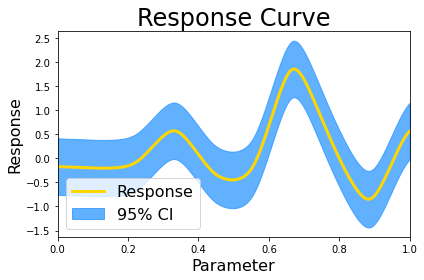

In [4]:
model_system.plot()

We now create our Bayesian optimization object. This is straightforward and can be done as 

In [5]:
model_example = BasicBayesOpt(train_x,train_y,bounds=None,
                      acq_options={},model_options={})

IndexError: tuple index out of range

Note that the parameter variable needs to be two-dimensional. Right now it's just a 1-D variable. Fortunately there's a quick fix

In [6]:
train_x = np.atleast_2d(train_x).T
model_example = BasicBayesOpt(train_x,train_y,bounds=None,
                      acq_options={},model_options={})

You will notice that there are other parameters called bounds, acq_options, and model_options. These are optional and allow you to change the range of the parameters, customize the acquisition function, and change the surrogate model respectively. Documentation on these parameters is provided in the code, an example of a customized model is 

In [7]:
model_example_customized = BasicBayesOpt(train_x,train_y,
                      acq_options={},model_options={'type':'FixedNoiseGP','sd':1.0})

## Object methods

Having created the object, we now describe the methods of this object. There are 6 methods you need to know about,

1. print - this allows you to obtain information about the object in readible form
2. ask - provides a suggestion on where to test next given the observations in the model
3. answer - allows the user to add additional observations to the model
4. optimum - where is the current best parameter location
5. save - save a model to a file
6. load - load a model from a file

We demonstrate how to use these models in turn. 

### Print

Starting with print, this provides information on the version of the model, when it was created, and the options of the model. This allows for reproducible research, as when loading an older saved model you can know when it was produced and what the version of the code whas it was made with (looking at Github). Using print is trivial as

In [8]:
print('First created object')
print('____________________')
print(model_example)
print('Second created object')
print('____________________')
print(model_example_customized)

First created object
____________________
BasicBayesOpt object
Version 1.2.2
Creation date 2022-05-25 14:31:09.845574
Fitted False
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Acquisition function parameters:
type: noisy_ei
raw_samples: 512
num_candidates: 1
num_restarts: 20
>>>>>>>>>>>>>>>>>
Model parameters:
type: SingleTaskGP
sd: 0.25

Second created object
____________________
BasicBayesOpt object
Version 1.2.2
Creation date 2022-05-25 14:31:11.446067
Fitted False
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Acquisition function parameters:
type: noisy_ei
raw_samples: 512
num_candidates: 1
num_restarts: 20
>>>>>>>>>>>>>>>>>
Model parameters:
type: FixedNoiseGP
sd: 1.0



### Save

Reproducing research requires that the results be saved. This is done with the save method. This is also easy to use

In [9]:
model_example.save('ExampleFile.p')

### Load

We can then load a saved model from a file

In [10]:
model_example_customized.load('ExampleFile.p')
print(model_example_customized)

BasicBayesOpt object
Version 1.2.2
Creation date 2022-05-25 14:31:09.845574
Fitted True
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Acquisition function parameters:
type: noisy_ei
raw_samples: 512
num_candidates: 1
num_restarts: 20
>>>>>>>>>>>>>>>>>
Model parameters:
type: SingleTaskGP
sd: 0.25



Notice that the options (and data) were overwritten. So only call load *with a newly created model*, not one used in an experiment. We actually provide error checking to prevent this from happening once you record new observations but it's better to not rely on error checking. This is particularly important because some of the parameters for the acquisition function or surrogate model might change

### Ask

This provides a suggestion on what the parameter should be

In [11]:
candidate_parameter = model_example.ask()
print(candidate_parameter)

/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755832681/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


[[0.]]


Ignore the red text. We actually don't have any control over the message anyway. For some reason Pytorch made some changes that weren't coordinated with Botorch. It whines now but doesn't have any significance

### Answer 

This provides the results. By separating ask and answer if there is a bit of error in where test was actually performed 

In [12]:
print('Observations to date:')
print(model_example.train_x)
parameter_tested = 0.5*np.ones((1,1))
fake_response = 2.9*np.ones((1,1))
model_example.answer(parameter_tested,fake_response)
print('Observations to date:')
print(model_example.train_x)

Observations to date:
[[0.9590803 ]
 [0.5591871 ]
 [0.83876128]
 [0.57548614]
 [0.55371099]
 [0.10776464]
 [0.30643406]
 [0.37701682]
 [0.71685506]
 [0.904184  ]]
Observations to date:
[[0.9590803 ]
 [0.5591871 ]
 [0.83876128]
 [0.57548614]
 [0.55371099]
 [0.10776464]
 [0.30643406]
 [0.37701682]
 [0.71685506]
 [0.904184  ]
 [0.5       ]]


Notice that the observations now include the value at 0.5

### Optimum

At the end of your experiment you will want to know where the best location is based on the current data

In [13]:
best_param = model_example.optimum()
print(best_param)

[0.5]


## A synthetic experiment in practice

Having described how the code functions, we now provide a demonstration of how to incorporate this into a single procedure. We return to the example with the synthetic system. As a reminder, here is our true response curve

Optimal parameter value: [0.67136714]
True response: 1.8577889285996207


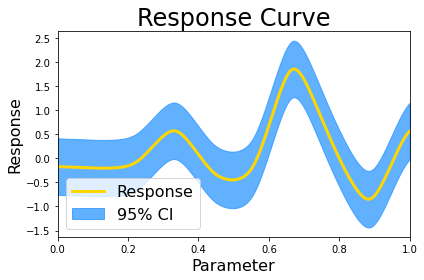

In [14]:
model_system.plot()
print('Optimal parameter value:',model_system.param_max)
print('True response:',model_system.response_max)

In [15]:
NUM_EXPERIMENTS = 5
NUM_SAMPLES = 30
NUM_INITIAL_SAMPS = 3

### First run
We perform the first experiment and detail every step. The remaining 4 will have less explanation

In [17]:
initial_stim_params = rand.uniform(low=0,high=1,size=NUM_INITIAL_SAMPS)
initial_responses = np.array([model_system.sample(initial_stim_params[i]) for i in range(NUM_INITIAL_SAMPS)])

In [18]:
train_x = np.atleast_2d(initial_stim_params).T
model_bo = BasicBayesOpt(train_x,initial_responses)

We will record four values at each iteration. (1) where the model suggets we test. (2) Where we tested. (3) What the response is.(4) Where the model thinks is optimal. (5) What the true function value at the predicted optimal point is. (1) and (2) are identical here as we assume that the experimenter test at the best location. In another demo however that will not be assumed.

In [19]:
suggested_parameter_list = []
tested_parameter_list = []
recorded_response_list = []
optimal_value_list = []
optimal_location_list = []

for i in range(NUM_SAMPLES):
    suggested_parameter = model_bo.ask() 
    response = model_system.sample(suggested_parameter) # Run trial
    model_bo.answer(suggested_parameter,response*np.ones((1,1))) # Record answer
    current_optimum = model_bo.optimum(tested=False)
    
    # Recording the results
    suggested_parameter_list.append(suggested_parameter[0,0])
    tested_parameter_list.append(suggested_parameter[0,0])
    recorded_response_list.append(response[0])
    optimal_location_list.append(current_optimum[0])
    optimal_value_list.append(model_system.response(current_optimum[0]*np.ones((1,1)))[0])

/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/chole

Text(0.5, 1.0, 'Improving Response')

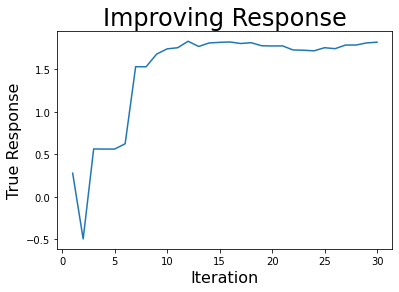

In [20]:
fs1 = 16
fs2 = 24
plt.plot(1+np.arange(NUM_SAMPLES),np.array(optimal_value_list))
plt.xlabel('Iteration',fontsize=fs1)
plt.ylabel('True Response',fontsize=fs1)
plt.title('Improving Response',fontsize=fs2)

Now we finish the remaining of the 5 trials

In [21]:
suggested_parameter_array = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
tested_parameter_array = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
recorded_response_array = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
optimal_value_array = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
optimal_location_array = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))

#Enter in the first experiment results
for i in range(NUM_SAMPLES):
    suggested_parameter_array[i,0] = suggested_parameter_list[i]
    tested_parameter_array[i,0] = tested_parameter_list[i]
    recorded_response_array[i,0] = recorded_response_list[i]
    optimal_value_array[i,0] = optimal_value_list[i]
    optimal_location_array[i,0] = optimal_location_list[i]


In [22]:
for j in range(1,NUM_EXPERIMENTS):
    initial_stim_params = rand.uniform(low=0,high=1,size=NUM_INITIAL_SAMPS)
    initial_responses = np.array([model_system.sample(initial_stim_params[i]) for i in range(NUM_INITIAL_SAMPS)])
    train_x = np.atleast_2d(initial_stim_params).T
    model_bo = BasicBayesOpt(train_x,initial_responses)
    
    for i in range(NUM_SAMPLES):
        suggested_parameter = model_bo.ask()
        response = model_system.sample(suggested_parameter) # Run trial
        model_bo.answer(suggested_parameter,response*np.ones((1,1))) # Record answer
        current_optimum = model_bo.optimum(tested=False)
    
        suggested_parameter_array[i,j] = suggested_parameter[0,0]
        tested_parameter_array[i,j] = suggested_parameter[0,0]
        recorded_response_array[i,j] = response[0]
        optimal_location_array[i,j] = current_optimum[0]
        optimal_value_array[i,j] = model_system.response(current_optimum[0]*np.ones((1,1)))[0]

/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/chole

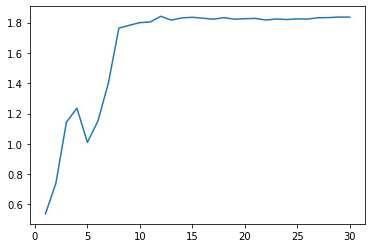

In [23]:
iteration_list = 1 + np.arange(NUM_SAMPLES)
plt.plot(iteration_list,np.mean(optimal_value_array,axis=1))

## Comparison to random guessing

This is actually straightforward. Rather than using a suggested parameter, we instead just use a randomly sampled parameter

In [24]:
suggested_parameter_array_no_bo = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
tested_parameter_array_no_bo = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
recorded_response_array_no_bo = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
optimal_value_array_no_bo = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))
optimal_location_array_no_bo = np.zeros((NUM_SAMPLES,NUM_EXPERIMENTS))

for j in range(1,NUM_EXPERIMENTS):
    initial_stim_params = rand.uniform(low=0,high=1,size=NUM_INITIAL_SAMPS)
    initial_responses = np.array([model_system.sample(initial_stim_params[i]) for i in range(NUM_INITIAL_SAMPS)])
    train_x = np.atleast_2d(initial_stim_params).T
    model_bo = BasicBayesOpt(train_x,initial_responses)
    
    for i in range(NUM_SAMPLES):
        suggested_parameter = model_bo.ask() 
        random_parameter = rand.uniform(low=0,high=1,size=1)*np.ones((1,1))
        response = model_system.sample(random_parameter) # Run trial
        model_bo.answer(suggested_parameter,response*np.ones((1,1))) # Record answer
        current_optimum = model_bo.optimum(tested=False)
    
        suggested_parameter_array_no_bo[i,j] = suggested_parameter[0,0]
        tested_parameter_array_no_bo[i,j] = random_parameter[0,0]
        recorded_response_array_no_bo[i,j] = response[0]
        optimal_location_array_no_bo[i,j] = current_optimum[0]
        optimal_value_array_no_bo[i,j] = model_system.response(current_optimum[0]*np.ones((1,1)))[0]

/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/utils/chole

Text(0.5, 1.0, 'Why Bayesian Optimization')

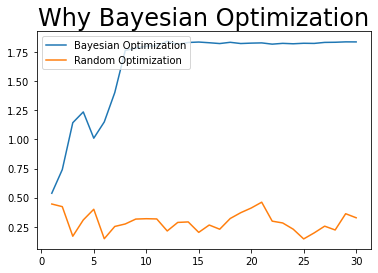

In [25]:
iteration_list = 1 + np.arange(NUM_SAMPLES)
plt.plot(iteration_list,np.mean(optimal_value_array,axis=1),label='Bayesian Optimization')
plt.plot(iteration_list,np.mean(optimal_value_array_no_bo,axis=1),label='Random Optimization')
plt.legend(loc='upper left')
plt.title('Why Bayesian Optimization',fontsize=fs2)